In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from commando import ComManDo
from commando.evaluation import *
from commando.utilities import predict_nn, predict_knn
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

2022-09-29 02:05:09.788302: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-29 02:05:09.788343: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
np.random.seed(42)

In [4]:
dataset_name = 'MMD-MA'
modality_names = ['Modality 1', 'Modality 2']
data1 = np.loadtxt("../data/Unioncom/MMD/s1_mapped1.txt")
data2 = np.loadtxt("../data/Unioncom/MMD/s1_mapped2.txt")
type1 = np.loadtxt("../data/Unioncom/MMD/s1_type1.txt")
type2 = np.loadtxt("../data/Unioncom/MMD/s1_type2.txt")
type1 = type1.astype(np.int)
type2 = type2.astype(np.int)
type1 = np.array([f'Cell Type {i}' for i in type1])
type2 = np.array([f'Cell Type {i}' for i in type2])

# Labels
labels = [type1, type2]
features = [None, None]

# Utility
positivize = lambda X: [x + x.min() for x in X]
minmax = lambda X: [(x + x.min()) for x in X]

# Preprocessing
data1 = preprocessing.scale(data1, axis=0)
data2 = preprocessing.scale(data2, axis=0)
data1[np.isnan(data1)] = 0  # Replace NaN with average
data2[np.isnan(data2)] = 0
data1 = preprocessing.MinMaxScaler().fit_transform(data1)
data2 = preprocessing.MinMaxScaler().fit_transform(data2)
dataset = [data1, data2]

# Replace NULL feature names
for i in range(len(features)):
    if features[i] is None:
        features[i] = np.array([f'Feature {i}' for i in range(dataset[i].shape[1])])

In [5]:
# Train-Test Imputation
train_size = int(.8 * len(data1))
train_idx = np.random.choice(range(len(data1)), train_size)
test_idx = np.array(list(set(range(len(data1))) - set(train_idx)))

In [6]:
# Reduced Priors
full_priors = np.eye(len(dataset[0]))

random_idx = np.random.choice(range(len(dataset[0])), int(.5 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
half_priors = np.diag(priors)

none_priors = np.zeros((len(dataset[0]), len(dataset[0])))

In [7]:
reduced_dim = 32

# ComManDo

In [8]:
# Integration
kwargs = {
    'output_dim': reduced_dim,
    'epoch_DNN': 10000,
    'log_DNN': 500,
    'use_early_stop': False,
    'batch_size': 256,
    'pca_dim': 2*[256],
    'dist_method': 'euclidean',
    'loss_weights': [1,1,1,1],
}
fromChar = [' ', '),', '(', ')', ',', '\'', '[', ']']
toChar = ['', '--', '', '', '-', '', '(', ')']
kwargs_str = str(sorted(kwargs.items()))[1:-1]
for f, t in zip(fromChar, toChar):
    kwargs_str = kwargs_str.replace(f, t)
hash_str = '---'.join([dataset_name, '-'.join([str(s) for s in dataset[0].shape]), '-'.join([str(s) for s in dataset[1].shape]), kwargs_str])

In [9]:
# Integration
cm = ComManDo(**kwargs)  # , match_result=cm.match_result, debug=True)
model_str = 'saved_models/cm---' + hash_str + '.h5'
try:
    # raise FileNotFoundError()
    cm.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
except FileNotFoundError:
    cm_data = cm.fit_transform(dataset=dataset)
    cm.save_model(model_str)
cm_data = cm.transform(dataset=dataset)

Loaded model 'saved_models/cm---MMD-MA---300-2000---300-1000---batch_size-256--dist_method-euclidean--epoch_DNN-10000--log_DNN-500--loss_weights-(1-1-1-1)--output_dim-32--pca_dim-(256-256)--use_early_stop-False.h5'


In [10]:
# Imputation
cm_im = ComManDo(**kwargs)
model_str = 'saved_models/cm_im---' + hash_str + '.h5'
try:
    # raise FileNotFoundError()
    cm_im.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
except FileNotFoundError:
    cm_im.fit_transform(dataset=[data1[train_idx], data2[train_idx]])
    cm_im.save_model(model_str)
cm_imputed = [cm_im.modal_predict(dataset[i][test_idx], i) for i in range(1, -1, -1)]

Loaded model 'saved_models/cm_im---MMD-MA---300-2000---300-1000---batch_size-256--dist_method-euclidean--epoch_DNN-10000--log_DNN-500--loss_weights-(1-1-1-1)--output_dim-32--pca_dim-(256-256)--use_early_stop-False.h5'


# Comparison Methods

In [11]:
integrated_data = [cm_data]
integrated_names = ['JAMIE']
colors = ['blue']

In [12]:
# NLMA
nlma_data, _ = mmd_combine(*dataset, method='maninetcluster', alignment='nonlinear manifold aln', num_dims=reduced_dim)
integrated_data.append(nlma_data)
integrated_names.append('NLMA')
colors.append('red')

In [13]:
# # LMA
# lma_data, _, _ = mmd_combine(*dataset, method='maninetcluster', alignment='linear manifold', num_dims=reduced_dim)
# integrated_data.append(lma_data)
# integrated_names.append('LMA')
# colors.append('orange')

In [14]:
# # CCA
# cca_data, _, _ = mmd_combine(*dataset, method='maninetcluster', alignment='cca', num_dims=reduced_dim)
# integrated_data.append(cca_data)
# integrated_names.append('CCA')
# colors.append('m')

In [15]:
# # MMD-MA
# from sklearn.metrics import pairwise_distances
# mmd_ma_data, _, _ = mmd_combine(pairwise_distances(dataset[0]), pairwise_distances(dataset[1]), method='mmd_ma', p=reduced_dim)
# integrated_data.append(mmd_ma_data)
# integrated_names.append('MMD-MA')
# colors.append('yellow')

In [16]:
# UnionCom
uc_data, _, _ = mmd_combine(*dataset, method='unioncom', output_dim=reduced_dim)
integrated_data.append(uc_data)
integrated_names.append('Unioncom')
colors.append('green')

use random seed: 666
Shape of Raw data
Dataset 0: (300, 2000)
Dataset 1: (300, 1000)
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
use device: cpu
epoch:[100/2000] err:18.2463 alpha:0.7467
epoch:[200/2000] err:7.6079 alpha:0.3344
epoch:[300/2000] err:5.7874 alpha:0.3945
epoch:[400/2000] err:4.4548 alpha:0.4520
epoch:[500/2000] err:3.8050 alpha:0.4898
epoch:[600/2000] err:3.4400 alpha:0.5147
epoch:[700/2000] err:3.2158 alpha:0.5321
epoch:[800/2000] err:3.0627 alpha:0.5454
epoch:[900/2000] err:2.9598 alpha:0.5564
epoch:[1000/2000] err:2.8918 alpha:0.5652
epoch:[1100/2000] err:2.8472 alpha:0.5728
epoch:[1200/2000] err:2.8168 alpha:0.5792
epoch:[1300/2000] err:2.7948 alpha:0.5847
epoch:[1400/2000] err:2.7798 alpha:0.5896
epoch:[1500/2000] err:2.7699 alpha:0.5940
epoch:[1600/2000] err:2.7644 alpha:0.5981
epoch:[1700/2000] err:2.7610 alpha:0.6018
epoch:[1800/2000] err:2.7583 alpha:0.6051
epoch:[1900/2000] err:2.7568 alpha:0.6081
epoch:[2000/2000] err:2

In [17]:
# Imputation
if False:
    imputation_name = 'Babel'
else:
    imputation_name = 'KNN'
    nn_imputed = [predict_knn(torch.tensor(dataset[i][train_idx]).float(), torch.tensor(dataset[(i+1)%2][train_idx]).float(), torch.tensor(dataset[i][test_idx]).float()) for i in range(1, -1, -1)]
imputed_data = [cm_imputed, nn_imputed][::-1]
imputed_names = ['JAMIE', imputation_name][::-1]

# Visualization

In [18]:
style='white'
sns.set(style=style)
plt.rcParams.update({'font.weight': 'normal',
                     'font.size': 18,
                     'axes.titlesize': 'large',
                     'axes.labelsize': 'large',
                     'xtick.labelsize': 'small',
                     'ytick.labelsize': 'small'})

In [19]:
%%capture
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

algorithm_elements = [Line2D([0], [0], marker='s', color='w', markerfacecolor=c, label=n, markersize=10) for n, c in zip(integrated_names, colors)]
label_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.rcParams['axes.prop_cycle'].by_key()['color'][i], label=l, markersize=10) for i, l in enumerate(np.unique(labels))]

# https://stackoverflow.com/a/47749903
fig, ax = plt.subplots()
legend = ax.legend(handles=label_elements, loc='center', frameon=False)
legend.figure.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.savefig('./output_figures/' + dataset_name + '-LabelLegend.png', bbox_inches=bbox, dpi=300)

fig, ax = plt.subplots()
legend = ax.legend(handles=algorithm_elements, loc='center', frameon=False)
legend.figure.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.savefig('./output_figures/' + dataset_name + '-AlgorithmLegend.png', bbox_inches=bbox, dpi=300)

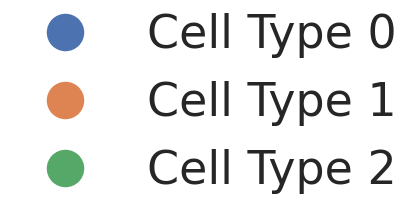

In [20]:
from IPython.display import Image
Image(filename='./output_figures/' + dataset_name + '-LabelLegend.png', width=100)

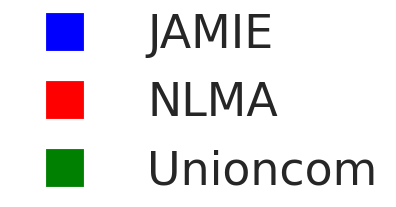

In [21]:
from IPython.display import Image
Image(filename='./output_figures/' + dataset_name + '-AlgorithmLegend.png', width=100)

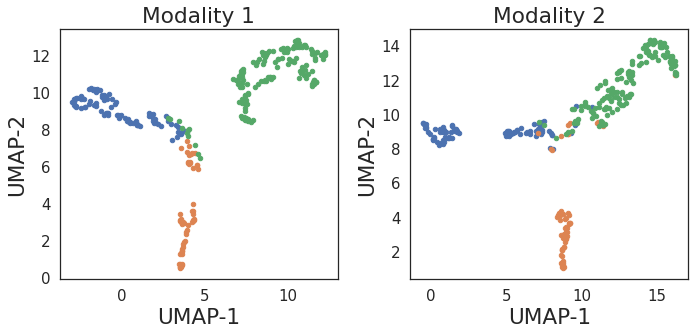

In [22]:
fig = plt.figure(figsize=(10, 5))
plot_regular(dataset, labels, modality_names)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Data.png', dpi=300)

In [23]:
# fig = plt.figure(figsize=(10, 5))
# plot_integrated(cm_data, labels, ['JAMIE - ' + mn for mn in modality_names])
# plt.tight_layout()
# plt.savefig('./output_figures/' + dataset_name + '-JAMIE.png', dpi=300)

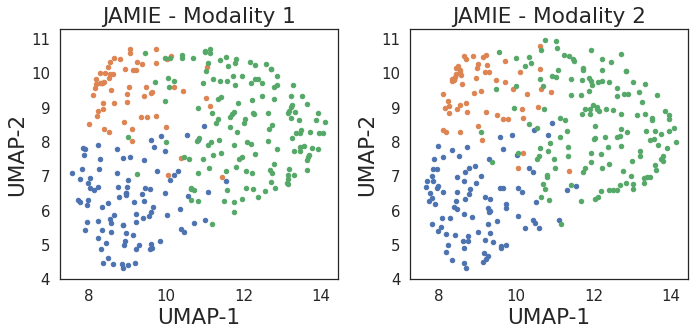

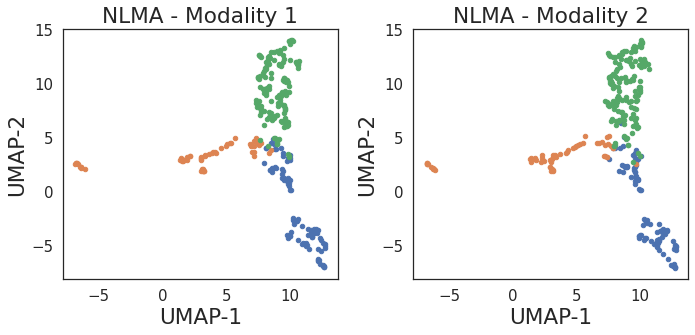

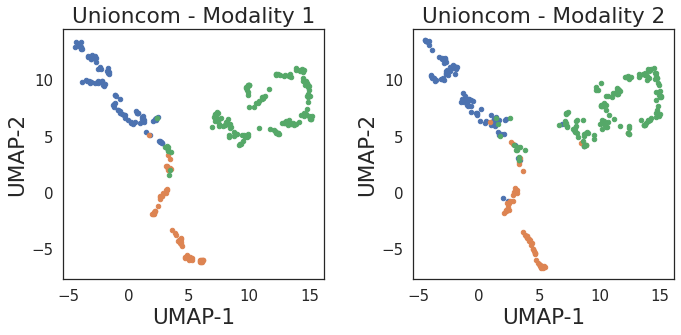

In [24]:
for d, n in zip(integrated_data, integrated_names):
    fig = plt.figure(figsize=(10, 5))
    plot_integrated(d, labels, [f'{n} - ' + mn for mn in modality_names], legend=False)
    plt.tight_layout()
    plt.savefig('./output_figures/' + dataset_name + f'-{n}.png', dpi=300)
    plt.show()

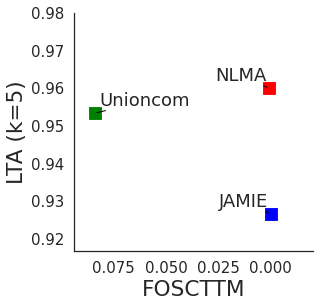

In [25]:
plt.figure(figsize=(5, 5))
plot_accuracy_graph(integrated_data, labels, integrated_names, colors=colors)
sns.despine()
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Acc.png', dpi=300)

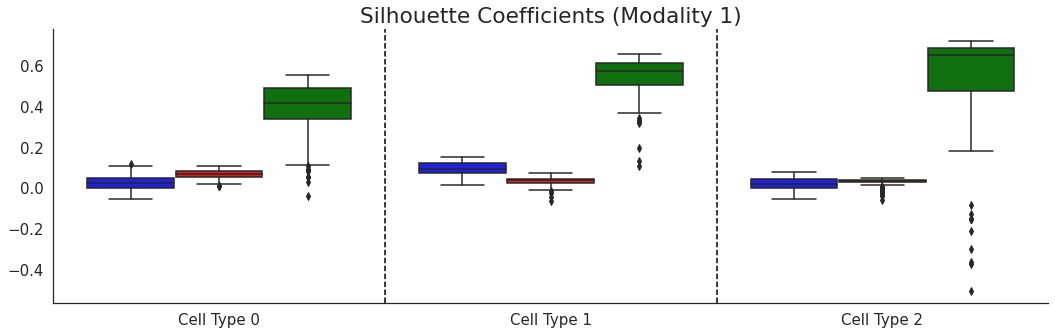

In [26]:
plt.figure(figsize=(15, 5))
plot_silhouette([[d[0]] for d in integrated_data], [labels[0]], integrated_names, modality_names[:1], colors=colors)
sns.despine()
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Sil.png', dpi=300)

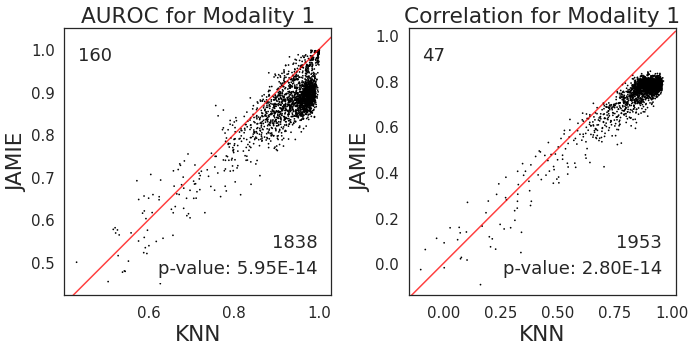

In [27]:
plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=0, names=imputed_names)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Imp1.png', dpi=300)

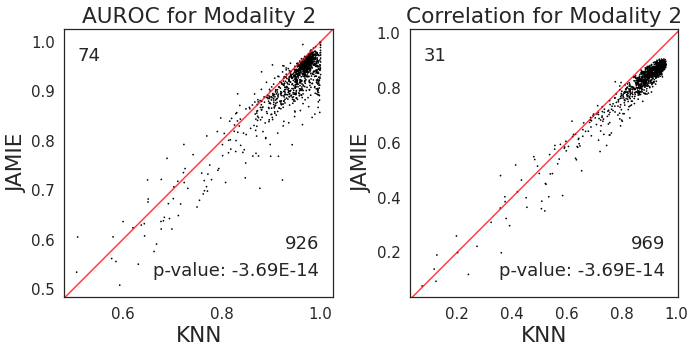

In [28]:
plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=1, names=imputed_names)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Imp2.png', dpi=300)

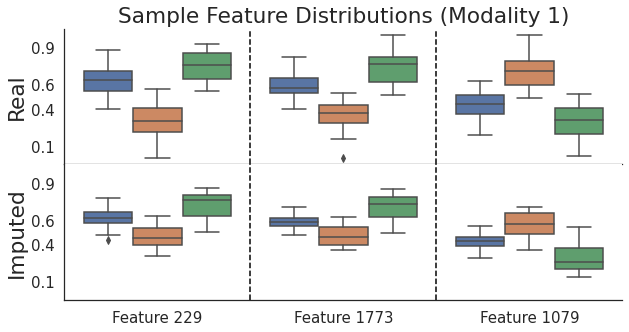

In [29]:
plt.figure(figsize=(10, 5))
plot_distribution_alone([dataset[0][test_idx], cm_imputed[0]], 2*[labels[0][test_idx]], title=modality_names[0], fnames=2*[features[0]])
sns.despine()
plt.savefig('./output_figures/' + dataset_name + '-Dist1.png', dpi=300)

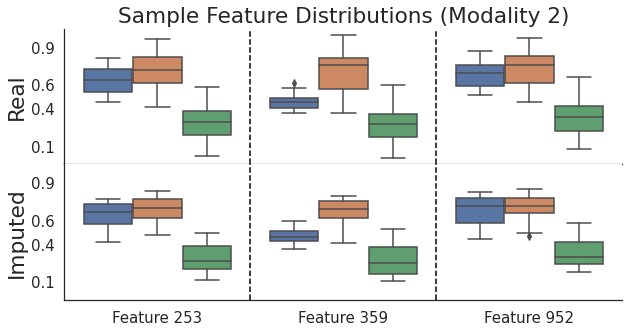

In [30]:
plt.figure(figsize=(10, 5))
plot_distribution_alone([dataset[1][test_idx], cm_imputed[1]], 2*[labels[1][test_idx]], title=modality_names[1], fnames=2*[features[1]])
sns.despine()
plt.savefig('./output_figures/' + dataset_name + '-Dist2.png', dpi=300)

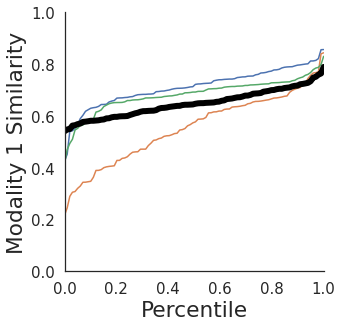

In [31]:
plt.figure(figsize=(5, 5))
plot_distribution_similarity([dataset[0][test_idx], cm_imputed[0]], 2*[labels[0][test_idx]], title=modality_names[0], fnames=2*[features[0]])
sns.despine()
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Sim1.png', dpi=300)

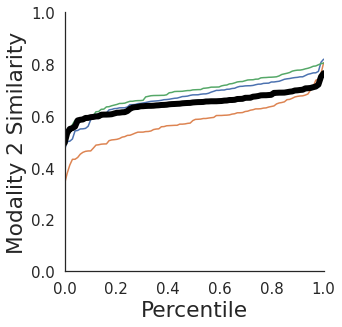

In [32]:
plt.figure(figsize=(5, 5))
plot_distribution_similarity([dataset[1][test_idx], cm_imputed[1]], 2*[labels[1][test_idx]], title=modality_names[1], fnames=2*[features[1]])
sns.despine()
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Sim2.png', dpi=300)

# Explanation

In [33]:
mod0, mod1 = 1, 0
current_cm = cm_im

In [34]:
from scipy import stats

# Omit one testing
in_data = dataset[mod0].copy()
# target = interest[0]  # Imputation
# target_name = features[mod1][target]  # Imputation
target_name = 'LTA'  # LTA
# out_data = dataset[mod1][:, target]  # Imputation

background = in_data.mean(0)
# logits = current_cm.modal_predict(in_data, mod0)[:, target]  # Imputation
logits = current_cm.test_LabelTA(2*[current_cm.transform_one(in_data, mod0)], labels)  # LTA
# baseline = stats.pearsonr(logits, out_data)  # Imputation
baseline = logits  # LTA

performance = []
best_idx = -1
best_perf = -np.inf
best_str = ''
check_best = 10
testing_idx = np.random.choice(dataset[mod0].shape[1], int(1e3), replace=False)
# testing_idx = np.array(range(in_data.shape[1]))
for i, idx in enumerate(testing_idx):
    # CLI
    if (i+1) % check_best == 0 and len(performance) > 0:
        best_idx = np.argmax(-np.array(performance))  # Replace one
        # best_idx = np.argmax(performance)  # Keep one
        best_perf = performance[best_idx]
        best_str = features[mod0][testing_idx[best_idx]]
    prog_str = math.floor(50*(i+1)/len(testing_idx)) * '|'
    print(
        f'{i+1:>{len(str(len(testing_idx)))}}/{len(testing_idx)} [{prog_str:<50}] - '
        f'Current Best: {best_perf:.5f}, {best_str}'
        , end='\r')
    
    mod_data = in_data
    # Replace one
    replace_idx = idx  # Replace one
    # replace_idx = [i!=idx for i in range(mod_data.shape[1])]  # Keep one
    old_data = mod_data[:, replace_idx]
    mod_data[:, replace_idx] = background[replace_idx]
    
    # Predict
    # logits = current_cm.modal_predict(mod_data, mod0)[:, target]  # Imputation
    logits = current_cm.test_LabelTA(2*[current_cm.transform_one(mod_data, mod0)], labels)  # LTA
    
    # Repair
    mod_data[:, replace_idx] = old_data
    
    # Record
    # perf = stats.pearsonr(logits, out_data)[0]  # Imputation
    # # perf = -np.sum((logits - out_data)**2)  # Imputation
    perf = logits  # LTA
    if np.isnan(perf):
        perf = -np.inf
    performance.append(perf)
print('\nDone!')
performance = np.array(performance)

1000/1000 [||||||||||||||||||||||||||||||||||||||||||||||||||] - Current Best: 0.91333, Feature 642
Done!


In [49]:
argsort_perf = np.argsort(performance)  # Replace one
# argsort_perf = np.argsort(performance)[::-1]  # Keep one

sorted_idx = testing_idx[argsort_perf]
sorted_names = features[mod0][sorted_idx]
sorted_perf = performance[argsort_perf]

display = 20
print(f'Target {modality_names[mod1]} Feature: {target_name}')
print(f'https://www.genecards.org/cgi-bin/carddisp.pl?gene={target_name}')
importance = features[mod0][sorted_idx][:display]
imp_str = ', '.join(importance)
print(f'Important {modality_names[mod0]} Features: {imp_str}')
for n, p in zip(importance, sorted_perf[:display]):
    print(f'{p:.5f}: https://www.genecards.org/cgi-bin/carddisp.pl?gene={n}')

Target Modality 1 Feature: LTA
https://www.genecards.org/cgi-bin/carddisp.pl?gene=LTA
Important Modality 2 Features: Feature 897, Feature 702, Feature 595, Feature 801, Feature 936, Feature 478, Feature 800, Feature 623, Feature 21, Feature 209, Feature 769, Feature 173, Feature 929, Feature 654, Feature 269, Feature 179, Feature 964, Feature 272, Feature 148, Feature 329
0.49667: https://www.genecards.org/cgi-bin/carddisp.pl?gene=Feature 897
0.68000: https://www.genecards.org/cgi-bin/carddisp.pl?gene=Feature 702
0.69000: https://www.genecards.org/cgi-bin/carddisp.pl?gene=Feature 595
0.69333: https://www.genecards.org/cgi-bin/carddisp.pl?gene=Feature 801
0.69333: https://www.genecards.org/cgi-bin/carddisp.pl?gene=Feature 936
0.69333: https://www.genecards.org/cgi-bin/carddisp.pl?gene=Feature 478
0.69667: https://www.genecards.org/cgi-bin/carddisp.pl?gene=Feature 800
0.69667: https://www.genecards.org/cgi-bin/carddisp.pl?gene=Feature 623
0.70000: https://www.genecards.org/cgi-bin/carddi

## SHAP

In [36]:
# RNA (Place) -> ATAC
# ENSG00000251562 (4) -> HYLS1
# ENSG00000251562 (4) -> HYLS1

# ATAC (Place) -> RNA
# ANKRD16 -> ENSG00000138119
# PWWP2B

In [37]:
# import shap

# # Subset for runtime
# use_subsetting = True
# subset_idx = np.random.choice(dataset[mod0].shape[1], 100, replace=False)
# background = np.mean(dataset[mod0], axis=0).reshape((1, -1))
# def take_subset(x, do=use_subsetting):
#     if not do:
#         return x
#     if len(x.shape) == 1:
#         return x[subset_idx]
#     return x[:, subset_idx]
# def reverse_subset(x, do=use_subsetting):
#     if not do:
#         return x
#     new_vec = np.concatenate(x.shape[0] * [background], axis=0)
#     new_vec[:, subset_idx] = x
#     return new_vec

# target_feature = interest[0]
# model = lambda x: current_cm.modal_predict(reverse_subset(x), mod0)[:, target_feature]
# data = dataset[mod0]
# back = background
# feature_names = features[mod0]
# output_names = features[mod1][target_feature]

# # Apply subsetting
# data = take_subset(data)
# back = take_subset(back)
# feature_names = list(take_subset(np.array(feature_names)))

# # Explainer
# explainer = shap.Explainer(model, back, feature_names=feature_names, output_names=output_names)
# shap_values = explainer(data, max_evals=2*data.shape[1]+1)

In [38]:
# display = 20
# print(f'Target {modality_names[mod1]} Feature: {output_names}')
# for n in [output_names]:
#     print(f'https://www.genecards.org/cgi-bin/carddisp.pl?gene={n}')
# importance = np.array(shap_values.feature_names)[np.argsort(shap_values.abs.mean(0).values)][::-1][:display]
# # importance = np.array(shap_values.feature_names)[np.argsort(shap_values.mean(axis=0).abs.values)[::-1][:display]]
# # importance = np.array(shap_values.feature_names)[np.argsort(shap_values.abs.max(axis=0).abs.values)[::-1][:display]]
# imp_str = ', '.join(importance)
# print(f'Important {modality_names[mod0]} Features: {imp_str}')
# for n in importance:
#     print(f'https://www.genecards.org/cgi-bin/carddisp.pl?gene={n}')

In [39]:
# plt.figure(figsize=(10, 5))
# ax = plt.gcf().add_subplot(1, 1, 1)
# shap.summary_plot(shap_values, data, plot_type='violin', max_display=display, plot_size=(9.2, 5), show=False)
# plt.tight_layout()
# plt.savefig('./output_figures/' + dataset_name + '-Summary.png');

In [40]:
# plt.figure(figsize=(10, 5))
# shap.plots.heatmap(shap_values, max_display=7, show=False)  # 7 because problem with visualization and tight layout
# plt.gca().set_xlabel('Samples')
# plt.tight_layout()
# plt.savefig('./output_figures/' + dataset_name + '-Heat.png');

In [41]:
# plt.figure(figsize=(10, 5))
# ax = plt.gcf().add_subplot(1, 1, 1)
# shap.dependence_plot(np.argsort(np.abs(shap_values.values).mean(0))[::-1][0], shap_values.values, data, ax=ax, show=False)
# plt.tight_layout()
# plt.savefig('./output_figures/' + dataset_name + '-Dep1.png');

In [42]:
# plt.figure(figsize=(10, 5))
# ax = plt.gcf().add_subplot(1, 1, 1)
# shap.plots.waterfall(100*shap_values[0], show=False)
# plt.tight_layout()
# plt.savefig('./output_figures/' + dataset_name + '-Waterfall1.png');

## Interactive

In [43]:
# # Kernel Explainer
# kexplainer = shap.KernelExplainer(model, shap.kmeans(data, 10), feature_names=feature_names, output_names=output_names)
# import warnings
# with warnings.catch_warnings():
#     warnings.simplefilter('ignore')
#     kshap_values = kexplainer.shap_values(data, nsamples=100)

In [44]:
# shap.force_plot(kexplainer.expected_value, kshap_values[0, :], data[0, :], matplotlib=True, show=False)
# plt.savefig('./output_figures/' + dataset_name + '-Force.png', bbox_inches='tight');

In [45]:
# shap.initjs()
# shap.force_plot(kexplainer.expected_value, kshap_values, data)